In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from plotnine import *
from sklearn.model_selection import train_test_split

## Task 1
We load the forest covertype dataset into a pandas dataframe.

In [70]:
df = pd.read_csv("covtype.csv", sep=',')

## Task 2
We plot the class distribution of the target variable 'Cover_Type' in the form of a histogram. The plot tells us that the distribution is highly skewed in favor of two of the seven classes. This could lead to the trained model having lower prediction accuracy on the classes that are under-represented as it will potentially "learn" less about them simply as a result of encountering them less often.

c:\Users\aujo8\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 251'. Pick better value with 'binwidth'.


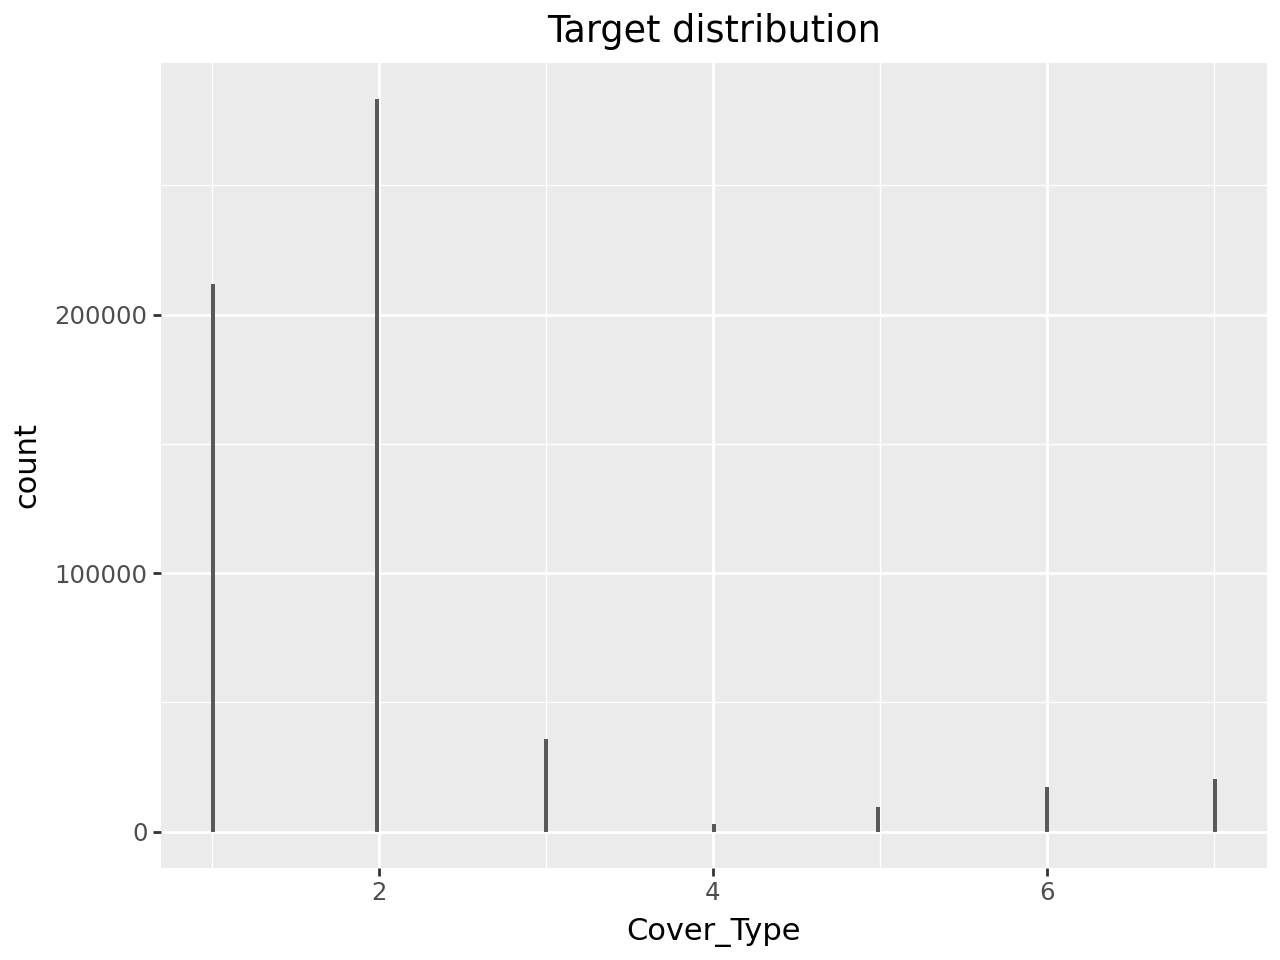

In [71]:
ggplot(df, aes(x="Cover_Type")) +\
    geom_histogram() +\
    ggtitle("Target distribution")

## Task 3
Below we have created a function that standardizes the columns of whatever data it is given. As will become evident from the following tasks we don't actually perform the standardization just yet.

In [72]:
def standardize(data):
    m = np.mean(data, axis=0)
    s = np.std(data, axis=0)
    strd_data = (data - m)/s
    return strd_data

## Task 4
Standardization is important from the perspective of increasing the robustness of the optimization. Having wildly different ranges in different features could potentially lead to very large deviations as a result of the noise that is incorporated by the stochastic gradient descent.

The standardization should take place **after** the split into training, validation and test data. This is because the mean and standard deviation might no longer be entirely representative for the subsets of data if they are calculated using the whole dataset. In our case, it probably doesn't make a lot of difference, due to the large sizes of even the subsets, but in order to follow good practice, we split the data first.

## Task 5
We will now go ahead and split the data into training, validation and test. After that, we perform the standardization of the numerical features (the first ten columns) of each subset separately. We also split each subset into input variables X and target variables y. When creating the target variables y we also go ahead and convert them into 1x7 indicator vectors such that position *i* is equal to 1 if that observation belongs to covertype number *i* and 0 otherwise.

In [73]:
train, testval = train_test_split(df, test_size=0.2, random_state=19970128)
test, val = train_test_split(testval, test_size=0.5, random_state=19970128)

In [91]:
# standardizing the non-categorical features (the first ten features)
# also seperating the data into targets y and input features X
X_train = pd.concat([standardize(train.iloc[:, 0:10]), train.iloc[:, 10:-1]], axis=1)
y_train = pd.get_dummies(train["Cover_Type"], dtype=int)

X_test = pd.concat([standardize(test.iloc[:, 0:10]), test.iloc[:, 10:-1]], axis=1)
y_test = test["Cover_Type"]

X_val = pd.concat([standardize(val.iloc[:, 0:10]), val.iloc[:, 10:-1]], axis=1)
y_val = pd.get_dummies(val["Cover_Type"], dtype=int)

## Task 6
In order to build a neural network and implement its trainin we are going to use the **PyTorch** library. There are several parameters and properties to be adressed when building a neural network. Below are the motivations for each of the choices.

#### Motivations
 - **Depth**: Our model consists of five hidden layers. We arrived at this from starting with zero layers and then adding one layer at a time until we deemed the improvements in training to be diminished.
 - **Width**: We follow the heuristic of smoothly increasing the width such that our widest layer should be close to the middle of the model, and then a similarly smooth decrease until the output layer. During class, we were given the 2x heuristic, i.e. increase number of nodes from one layer to the next by 2x. 
 Our model's widths:
     - input: 54,
     - hidden layers: 108 --> 216 --> 216 --> 108 --> 54,
     - output layer: 7 
 - **Activation functions**: The purpose of the activation functions is to introduce non-linearity such that we can eventually reach a representation of the data where it is linearly separable. The rectified linear unit (ReLU) is the most widely used activation function. Its gradient is constant (where it is differentiable) and it is fast to compute. We use this in all of our hidden layers.
 - **Loss function**: Because the task is classification, we model probabilities (between 0 and 1). As such, it is natural to maximize conditional log-likelihood, but this is closely related to minimizing cross-entropy. We thus choose the cross-entropy as our loss function.
 - **Output function**: We use the softmax function in order to model the final probabilities. This function generalizes the logistic function used in binary classification to more than two classes, and as such, is a natural way of modeling multinomial probabilities.
 - **Parameter initialization**: The parameter initializations take place automatically in the *nn.Linear()* functions in the *NerualNetwork* class. The method enmployed is the same for both biases and weights and is very similar to LeCun or Glorot initialization. The parameters are sampled uniformly on the (-sqrt(k), sqrt(k)) interval where k is defined as 1/#incoming features, thus ensuring that we are sampling values relatively close to zero. It is important to initialize weights close to zero as this allows for the necessary complexity of the model to develop through training as opposed to us imposing it.
 - **Training algorithm**: In order to make our optimization more robust against imbalanced curvature and to reduce variance, we want to choose a version of stochastic gradient descent that employs momentum that decays over time. One such algorithm is the adaptive moments algorithm called "Adam", and this will be our choice.  


In [88]:
import os
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

# if possible, running on GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "hip"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [96]:
# transforming our data into tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()

X_test_tensor = torch.tensor(X_test.values).float() 
y_test_tensor = torch.tensor(y_test.values)

X_val_tensor = torch.tensor(X_val.values).float()
y_val_tensor = torch.tensor(y_val.values).float()

In [ ]:
# creating torch datasets in preparation for mini batches
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

# the dataloaders for the mini batches
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

In [68]:
# defining the neural net
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 108),
            nn.ReLU(),
            nn.Linear(108, 216),
            nn.ReLU(),
            nn.Linear(216, 216),
            nn.ReLU(),
            nn.Linear(216, 108),
            nn.ReLU(),
            nn.Linear(108, 54),
            nn.ReLU(),
            nn.Linear(54, 7),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
# instantiating the model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=54, out_features=108, bias=True)
    (1): ReLU()
    (2): Linear(in_features=108, out_features=216, bias=True)
    (3): ReLU()
    (4): Linear(in_features=216, out_features=216, bias=True)
    (5): ReLU()
    (6): Linear(in_features=216, out_features=108, bias=True)
    (7): ReLU()
    (8): Linear(in_features=108, out_features=54, bias=True)
    (9): ReLU()
    (10): Linear(in_features=54, out_features=7, bias=True)
  )
)


In [78]:
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# per epoch losses
training_loss = []
validation_loss = []

# training/validation loop
for epoch in range(epochs):
    
    # training phase
    model.train()
    train_loss = 0.0
    print(f"Epoch {epoch+1}\n-------------------------------")
    for batch, (X, y) in enumerate(train_dl):
        # Move data to device
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dl)
    training_loss.append(avg_train_loss)
    print(f"Average training Loss: {avg_train_loss:.4f}")

    # validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():  # Disable gradient computation for validation
        for X, y in val_dl:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dl)
    validation_loss.append(avg_val_loss)
    print(f"Average validation Loss: {avg_val_loss:.4f}\n")


print("Training complete!")

Epoch 1
-------------------------------
Average training Loss: 0.5173
Average validation Loss: 0.4056

Epoch 2
-------------------------------
Average training Loss: 0.3578
Average validation Loss: 0.3181

Epoch 3
-------------------------------
Average training Loss: 0.2928
Average validation Loss: 0.2774

Epoch 4
-------------------------------
Average training Loss: 0.2533
Average validation Loss: 0.2492

Epoch 5
-------------------------------
Average training Loss: 0.2274
Average validation Loss: 0.2352

Epoch 6
-------------------------------
Average training Loss: 0.2081
Average validation Loss: 0.2101

Epoch 7
-------------------------------
Average training Loss: 0.1944
Average validation Loss: 0.2003

Epoch 8
-------------------------------
Average training Loss: 0.1828
Average validation Loss: 0.1903

Epoch 9
-------------------------------
Average training Loss: 0.1732
Average validation Loss: 0.1795

Epoch 10
-------------------------------
Average training Loss: 0.1655
Av

## Task 7
See plot below.

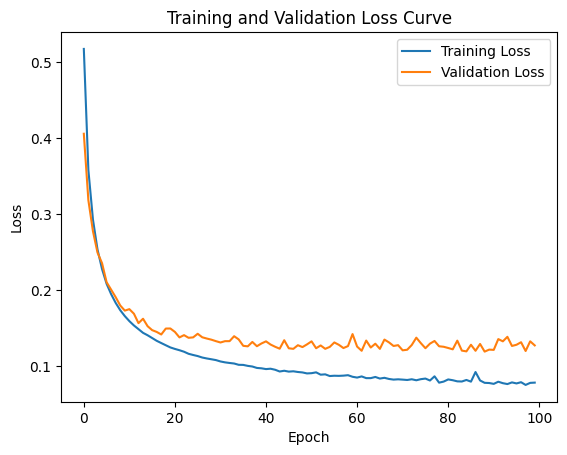

In [79]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Curve")
plt.show()

Judging from the training and validation loss plot:

 - has the training error converged?
    Yes, it looks relatively stable and seems to have reached a plateau.

 - does the validation curve look as expected?
    Yes, the validation looks as expected. Apart from the very beginning (which is still within the margin of error) of the curve, the validation is steadily sitting on top of the training. It also seems to plateau which is what we are looking for while minimizing the cross-entropy.

 - are there any indications of overfitting?
   Maybe some slight indications of starting to overfit around epoch 80 as we see some slightly larger spikes in the training curve there. These are still relatively small, however, and should rather just act as an indication of having reached a point of diminishing returns. In general, no indications of overfitting from the training curve.

## Task 8
Finally, we are going to assess the accuracy of our model by testing its prediction accuracy on the test data set that we created earlier.

In [110]:
model.eval()
with torch.no_grad():

    # input the test data into the model
    logits = model(X_test_tensor)

    # use the softmax function in order to model output as probabilities
    probs = F.softmax(logits, dim=1)

    # classify using highest-probability-wins rule
    # also add 1 to result in order to match the original class labels 1 to 7 (instead of 0 to 6)
    pred_labels = torch.argmax(probs, dim=1) + 1

true_labels = y_test_tensor

correct = 0
total = len(true_labels)
for i in range(total):
    if pred_labels[i] == true_labels[i]:
        correct += 1

accuracy = correct / total
print(f"Average prediction accuracy of model: {accuracy:.4f}\n")

Average prediction accuracy of model: 0.9569



The accuracy of the model on the test data evaluated to approximately 0.96. We can now return birefly to the second task, where we hypothesized that prediction would be worse for the under-represented classes. As an example, let us examine what proportion of misclassifications belong to class 4 (the most under-represented class) and compare it to the proportion of occurences of class 4 in the original dataset. Were the model to predict all classes equally accurate, we should expect to see these proportions matching.  

In [150]:
misclassified = np.array([int(true_labels[i]) for i in range(len(true_labels)) if true_labels[i] != pred_labels[i]])
count_class_4_misclass = 0
for i in range(len(misclassified)):
    if misclassified[i] == 4:
        count_class_4_misclass += 1

class_4_misclass_prop = count_class_4_misclass / len(misclassified)

targets = df["Cover_Type"].values
total_len = len(targets)
class_4_count = 0
for i in range(total_len):
    if targets[i] == 4:
        class_4_count += 1

total_class_4_prop = class_4_count / total_len

print(class_4_misclass_prop / total_class_4_prop)

2.1108565540923974


The above print-out is interpreted as: "among the misclassifications of our test data, observations truly belonging to class 4 occur more than twice as often as class 4 observations occur in the original data". This acts as evidence in favor of our hypothesis. Were we to adress this class imbalance in some productive way, we might be able to slightly increase the accuracy.

An accuracy of approx 0.96, however, is already really good and this suggests that our model generalizes well to unseen data. 

What could be studied further in order to better understand the accuracy are the specific misclassifactions, i.e. which classes are misclassified into what other classes. To do this, a confusion matrix could be employed, which we will leave below, without commenting on it (as this was not part of the assignment).

In [159]:
y_actu = pd.Series(true_labels, name='True')
y_pred = pd.Series(pred_labels, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,1,2,3,4,5,6,7
True,,,,,,,
1,20341,695,0,0,5,1,27
2,933,27301,38,0,77,44,3
3,0,34,3403,30,5,51,0
4,0,0,21,258,0,4,0
5,24,120,6,0,801,4,0
6,0,18,123,22,1,1591,0
7,187,31,0,0,1,0,1901
